In [118]:
%matplotlib inline
import pandas as pd
from glob import glob
import json
import numpy as np
import os

from sklearn import metrics

pd.set_option('display.max_rows', 500)


import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('paper')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# AAFC Salmonella AMR Analysis

Analyses of the 100 Salmonella Genomes from Moussa and Attiq:

- Serovar Prediction
    - Genomic Prediction
    - Molecular Prediction
    - Comparsion
- AMR Analysis
    - AMR determinant identification (summary)
    - AST testing (observed distribution)
    - Relationship between Genomic AMR and AST results
- Virulence Factor Analyses
- Targeted analysis
    - CMY-2 Analysis

## Serovar Prediction

A comparison of whole genome serotyping methods for the genomes specifically: SISTR and SeroSeq

### Genomic Prediction

This was conducted using:
- SeqSero (commit: `7e6348e42` with a bash runner script `'analyses/serotyping/run_seqsero_all_genomes.sh'`.  Setting `-m 4` for assemblies was used.)
- SISTR_cmd (version: `1.0.2` with a bash runner script `'analyses/serotyping/run_sistr_all_genomes.sh'`.  Settings `-qc` to get confidence measures, `-m` to run mash and the representative cgMLST dataset was used in place of the full one.). Results are then tidied using `analyses/serotyping/tidy_seqsero.py`

In [119]:
# SISTR results outputs to nice tabulated file
sistr_df = pd.read_csv('analyses/serotyping/sistr-output.tab', sep='\t')
# tidy up the genome name paths
sistr_df['genome'] = sistr_df['genome'].str.replace('../../genomes/', '').str.replace('.fasta', '')
# get genome ID from genome name and set index
sistr_df['ID'] = sistr_df['genome'].apply(lambda x: "_".join(x.split('_')[:-1]))
sistr_df = sistr_df.set_index("ID")
sistr_df = sistr_df.fillna('Unknown')

seqsero_df = pd.read_csv('analyses/serotyping/seqsero.tsv', sep='\t')
seqsero_df = seqsero_df.set_index('ID')
seqsero_df['serotype'] = seqsero_df['serotype'].fillna('Unknown')

# tidy up to just the genomes we have phenotypes for
ast_df = pd.read_excel('data/antibiotic_susceptibility_testing/Salmonella_AST_April18,2018..xlsx', sheet_name=1)
ast_df['ID'] = ast_df['ID'].astype(str)
ast_df = ast_df.set_index('ID')
# drop the following two genomes as we don't have genomes for them only AST typing
# 3346 and 3163
ast_df = ast_df.drop(['3346', '3163'])

sistr_df = sistr_df.loc[ast_df.index]
seqsero_df = seqsero_df.loc[ast_df.index]

### Concordance

How well do the different methods compare:

- SeroSeq
- SISTR mash
- SISTR cgMLST
- SISTR antigen
- SISTR overall prediction

In [120]:
seqsero_serovar = seqsero_df['serotype'].rename('seqsero')
sistr_df = sistr_df[['mash_serovar', 'serovar', 'serovar_cgmlst', 'serovar_antigen']]
sistr_df = sistr_df.rename(columns={'mash_serovar': 'sistr_mash', 'serovar': 'sistr_prediction', 
                                    'serovar_cgmlst': 'sistr_cgmlst',
                                    'serovar_antigen': 'sistr_antigen'})

# not all genomes have AAFC from Attiq so just filter to those that do by joining on AAFC AST data
serotype_comparisons = pd.DataFrame(sistr_df).join(seqsero_serovar)

# now we need to tidy up to make comparisons
# tidying up to make consistent comparisons
serotype_comparisons['seqsero'] = serotype_comparisons['seqsero'].str.replace('potential monophasic variant of ', '')
serotype_comparisons['seqsero'] = serotype_comparisons['seqsero'].replace('N/A (The predicted antigenic profile does not exist in the White-Kauffmann-Le Minor scheme)', 'None')

# use the same format as AAFC for this
serotype_comparisons = serotype_comparisons.replace('I 4,[5],12:i:-', 'I:4,[5],12:i:')
serotype_comparisons = serotype_comparisons.replace('enterica I:4,5,12:i:', 'I:4,[5],12:i:')
# replace all nan with "No Prediction"
serotype_comparisons = serotype_comparisons.fillna("None")

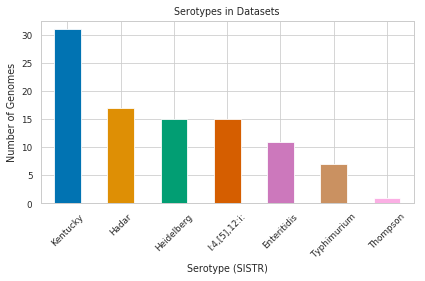

In [121]:
serotype_comparisons['sistr_prediction'].value_counts().plot(kind='bar')
plt.title('Serotypes in Datasets')
plt.ylabel('Number of Genomes')
plt.xticks(rotation=45)
plt.xlabel('Serotype (SISTR)')
plt.tight_layout()
plt.savefig('analyses/serotyping/serotypes.svg')
plt.savefig('analyses/serotyping/serotypes.pdf')

In [122]:
# set consistent colors for serotype
sero_lut = dict(zip(['Kentucky', 'Hadar', 'Heidelberg', 
                     'I4,[5],12:i:', 'Enteritidis', 
                     'Typhimurium', 'Thompson'], sns.color_palette().as_hex()))

In [123]:
# to assess overall performance lets tabulate the differences
# note this will only accept if its an exact match, no prevaricating between serotypes

def classification_summary(y_true, y_pred, label):
    report = metrics.classification_report(y_true, y_pred, y_true.unique())
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        line = line.split()
        row['class'] = line[0]
        row['precision'] = float(line[1])
        row['recall'] = float(line[2])
        row['f1_score'] = float(line[3])
        row['support'] = float(line[4])
        report_data.append(row)
    
    # get overall metrics
    overall = lines[-2].split()
    row = {'class': 'Overall avg/total',
           'precision': float(overall[3]),
           'recall': float(overall[4]),
           'f1_score': float(overall[5]),
           'support': float(overall[6])}
    
    report_data.append(row)
    df = pd.DataFrame(report_data)
    df['method'] = label
    
    return df

performance_data = []
for column in serotype_comparisons.drop('sistr_prediction', axis=1).columns:  
    classification_report = classification_summary(serotype_comparisons['sistr_prediction'], 
                                                   serotype_comparisons[column], 
                                                   column)
    performance_data.append(classification_report)

performance_data = pd.concat(performance_data)

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


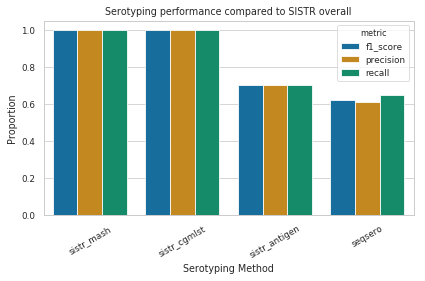

In [132]:
df = pd.melt(performance_data[performance_data['class'] == 'Overall avg/total'], id_vars = ['class', 'method'], var_name='metric')
df = df[df['metric'] != 'support']
g = sns.barplot(x='method', y='value', hue='metric', data = df)
_ = plt.xticks(rotation=30)
plt.ylabel('Proportion')
plt.xlabel('Serotyping Method')
plt.title('Serotyping performance compared to SISTR overall')
plt.tight_layout()
plt.savefig('analyses/serotyping/serotype_comparisons.svg')
plt.savefig('analyses/serotyping/serotype_comparisons.pdf')

Overall performance shows that the sistr methods are largely equal, seqsero and `sistr_antigen` have probably suffered by dint of me being strict and only counting correct results when they match exactly instead of giving a list of possibilities. 

In [134]:
df = performance_data[performance_data['class'] != 'Overall avg/total'] 

In [135]:
df = pd.melt(df, id_vars = ['class', 'method'], var_name='metric')
df = df[df['metric'] != 'support']

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


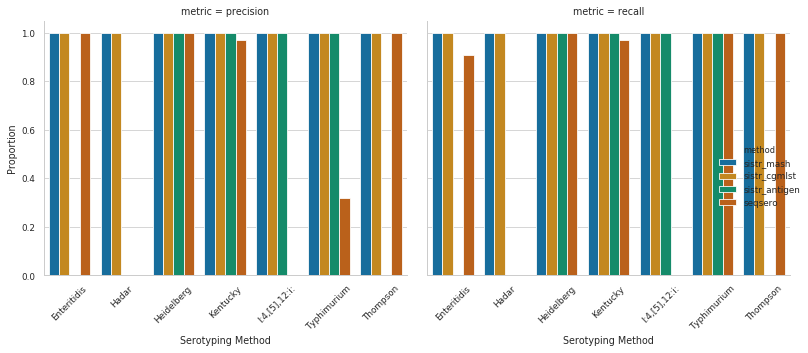

In [136]:
df = df[df['metric'] != 'f1_score']

g = sns.factorplot(kind='bar', x='class', y='value', col='metric', hue='method', data = df)
g.set_xticklabels(rotation=45)
g.set_ylabels('Proportion')
g.set_xlabels('Serotyping Method')
plt.tight_layout()


plt.savefig('analyses/serotyping/serotyping_performance_by_class.svg')
plt.savefig('analyses/serotyping/serotyping_performance_by_class.pdf')

### Summary

Looks like the serotyping performances pretty well regardless of method used. Seqsero and SISTR antigen methods suffer by dint of not being specific enough for the criteria.  It is possible these would improve if we are generous and allow ambiguous serotyping to count as a success if one of the options is the correct serotype e.g. seroseq outputting `Hadar or Istanbul`.

## AMR Analysis

An analysis of the AMR determinants present within the datasets as identified using RGI and the CARD database

### AST results

Parse and explore the AST results from Attiq

In [164]:
# replace their serotyping with our SISTR serotyping
ast_df['Serovar'] = serotype_comparisons['sistr_prediction'].loc[ast_df.index]
ast_df['Serovar'].unique()

array(['Enteritidis', 'Hadar', 'Heidelberg', 'Kentucky', 'I:4,[5],12:i:',
       'Typhimurium', 'Thompson'], dtype=object)

In [165]:
# set consistent colors for serotype
sero_lut = dict(zip(['Kentucky', 'Hadar', 'Heidelberg', 
                     'I:4,[5],12:i:', 'Enteritidis', 
                     'Typhimurium', 'Thompson'], sns.color_palette().as_hex()))

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


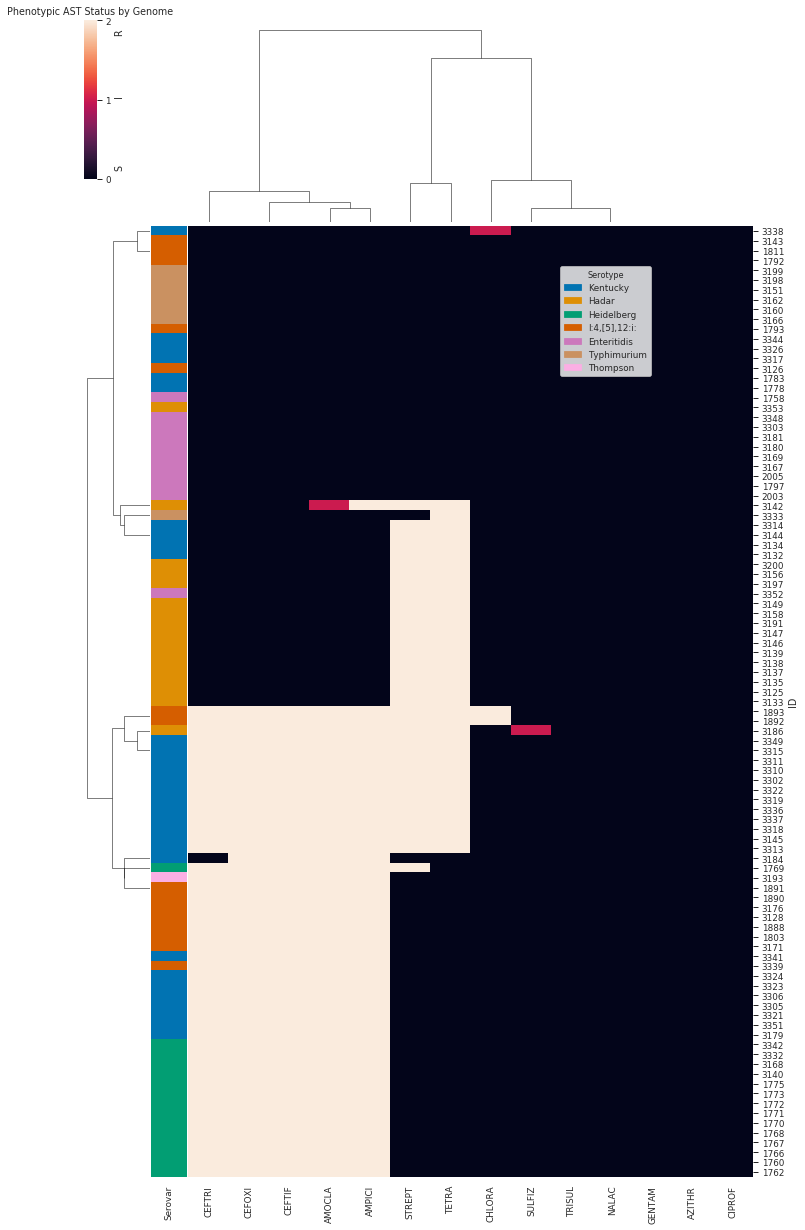

In [167]:
sir_labels = ast_df.loc[:, 'AMOCLA': 'TRISUL']
sir_labels[ast_df == 'S'] = 0
sir_labels[ast_df == 'I'] = 1
sir_labels[ast_df == 'R'] = 2
sir_labels = sir_labels.apply(pd.to_numeric)

sero = ast_df['Serovar'].loc[sir_labels.index]
colors = sero.map(sero_lut)

import matplotlib.patches as mpatches
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]

g = sns.clustermap(sir_labels, row_colors=colors, cbar_kws={'ticks': [0,1,2]}, xticklabels=True, 
                   yticklabels=True, figsize=(12,22))
plt.ylabel('S                      I                    R')
plt.title("Phenotypic AST Status by Genome")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.65,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
plt.subplots_adjust(bottom=0.15)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.tight_layout()
#plt.savefig('amr/ast_summary_clustermap')

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'amr/ast_summary_SIR.pdf'

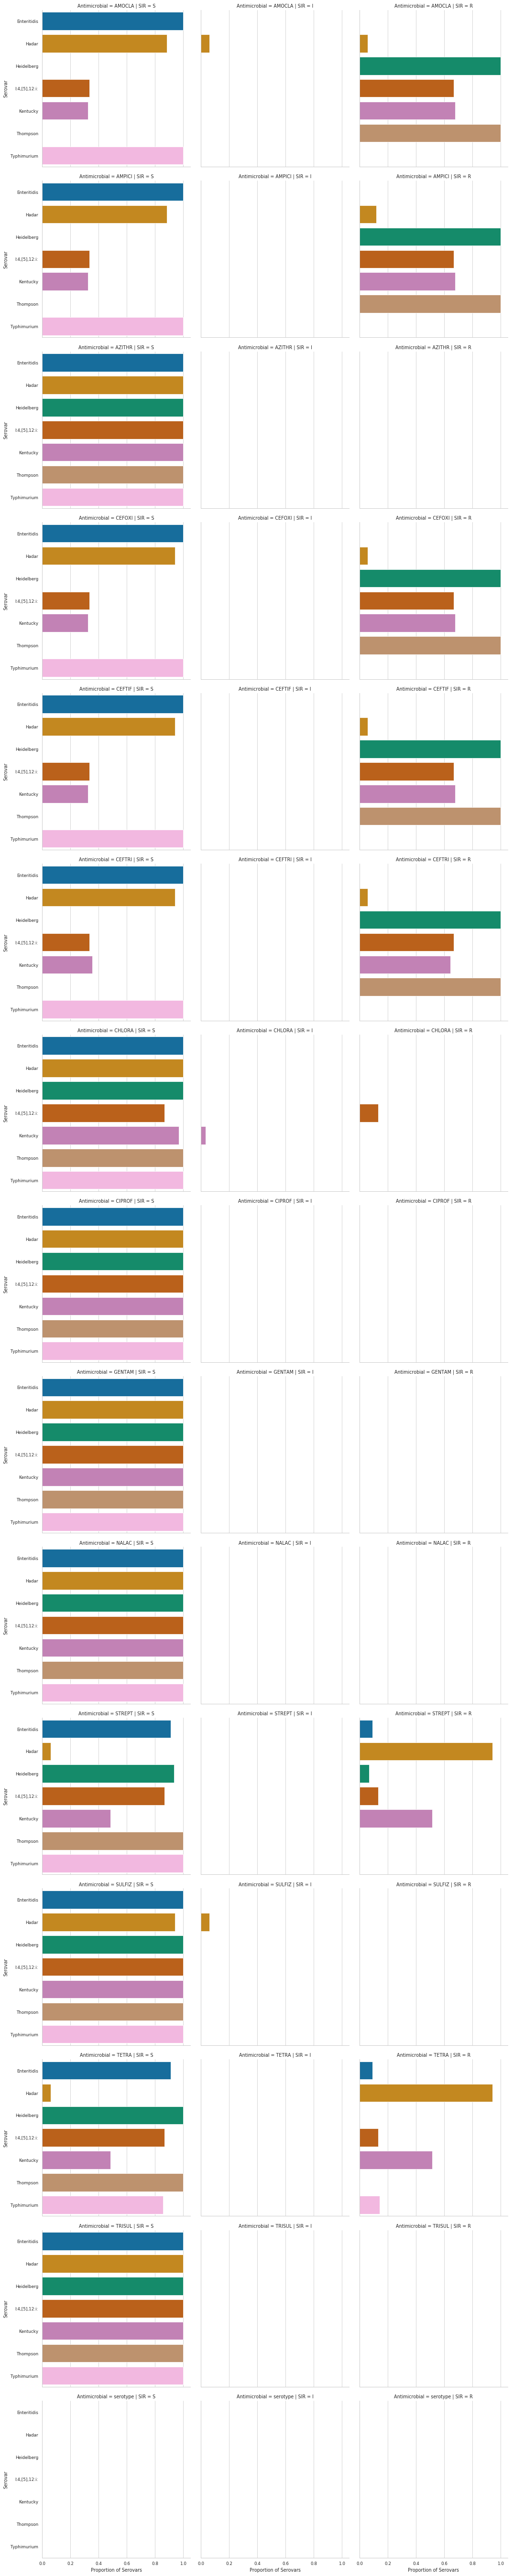

In [158]:
df = ast_df.drop("Date Read", axis=1)

# so we can normalise the counts
total_serovars_in_dataset = ast_df['Serovar'].value_counts()

# tally up the SIR statuses
df = pd.melt(df, id_vars='Serovar', var_name='Antimicrobial', value_name='SIR')
df = df.groupby(['Serovar', 'Antimicrobial', 'SIR']).size().unstack(fill_value=0).reset_index()

norm_df = df.set_index('Serovar').join(total_serovars_in_dataset)

norm_df['S'] = norm_df['S'] / norm_df['Serovar']
norm_df['I'] = norm_df['I'] / norm_df['Serovar']
norm_df['R'] = norm_df['R'] / norm_df['Serovar']

norm_df = norm_df.reset_index()
norm_df = norm_df.drop('Serovar', axis=1)
norm_df = norm_df.rename(columns={'index': 'Serovar'})
norm_df = pd.melt(norm_df, id_vars=['Serovar', 'Antimicrobial'], var_name='SIR', value_name='Proportion of Serovars')

sns.factorplot(data=norm_df, col = 'SIR', col_order = ['S', 'I', 'R'], row = "Antimicrobial", y="Serovar", x="Proportion of Serovars", kind='bar')
save_figure('amr/ast_summary_SIR')

In [34]:
ast_df.drop('Date Read', axis=1).replace('I', 0).replace('R', 1).replace('S', 0).to_csv('amr/phenotypic_ast/sir_labels.csv')

In [35]:
!R CMD amr/phenotypic_ast/upset_plot.r
# to plot all the upset plots

Error: package ‘scales’ was installed by an R version with different internals; it needs to be reinstalled for use with this R version
Execution halted


In [36]:
from IPython.display import IFrame
IFrame("amr/upset_all_ast.pdf", width=800, height=800)

In [37]:
IFrame("amr/upset_hadar_ast.pdf", width=800, height=800)

In [38]:
IFrame("amr/upset_heidelberg_ast.pdf", width=800, height=800)

In [39]:
IFrame("amr/upset_kentucky_ast.pdf", width=800, height=800)

In [40]:
IFrame("amr/upset_typhimurium_ast.pdf",  width=800, height=800)

In [41]:
IFrame("amr/upset_enterica_ast.pdf" , width=800, height=800)

### Genotypic AMR Prediction

Summary of the RGI based predictions from the genotypes

In [42]:
rgi_results = []
missing = []
for assembly_id in ast_df.index:
    rgi_output = glob('amr/amr_determinants/rgi_analysis/rgi_output/{}_irida-submission-*.fasta_rgi.txt'.format(assembly_id))
    if len(rgi_output) == 1:
        df = pd.read_csv(rgi_output[0], sep='\t')
        df['ID'] = assembly_id
        rgi_results.append(df)
    elif len(rgi_output) > 1:
        print("Multiple hits")
    else:
        missing.append(assembly_id)

print("Genome with AST but no data downloaded from IRIDA ID:{}".format(missing))
        
rgi_results = pd.concat(rgi_results)
rgi_results = rgi_results.reset_index()
rgi_results = rgi_results.set_index('ID')
rgi_results = rgi_results.drop('index', axis=1)


#Then discard all AST data where we don't have a genome
ast_df = ast_df.drop(missing, axis=0)


Genome with AST but no data downloaded from IRIDA ID:['3346', '3163']


In [43]:
def get_drug_classes_and_families_by_ID(df):
# gather up the drug classes and gene families by ID
# fill na with '' empty string to avoid issues with pd.nan being a float
    drug_class = {}
    gene_family = {}
    for row in df.fillna('').iterrows():
        if row[0] not in drug_class:
            drug_class.update({row[0]: [row[1]['Drug Class']]})
        else:
            drug_class[row[0]].append(row[1]['Drug Class'])
        if row[0] not in gene_family:
            gene_family.update({row[0]: [row[1]['AMR Gene Family']]})
        else:
            drug_class[row[0]].append(row[1]['Drug Class'])


    for key, value in drug_class.items():
        resistances = []
        for drug_list in value:
            for drug in drug_list.split(';'):
                if len(drug) != 0: 
                    resistances.append(drug.strip())

        drug_class[key] = resistances


    for key, value in gene_family.items():
        families = []
        for family_list in value:
            for family in family_list.split(';'):
                families.append(family.strip())

    gene_family[key] = families
    return drug_class, gene_family
    
drug_class, gene_family = get_drug_classes_and_families_by_ID(rgi_results)
perfect_drug_class, \
perfect_gene_family = get_drug_classes_and_families_by_ID(rgi_results[rgi_results['Cut_Off']=='Perfect'])

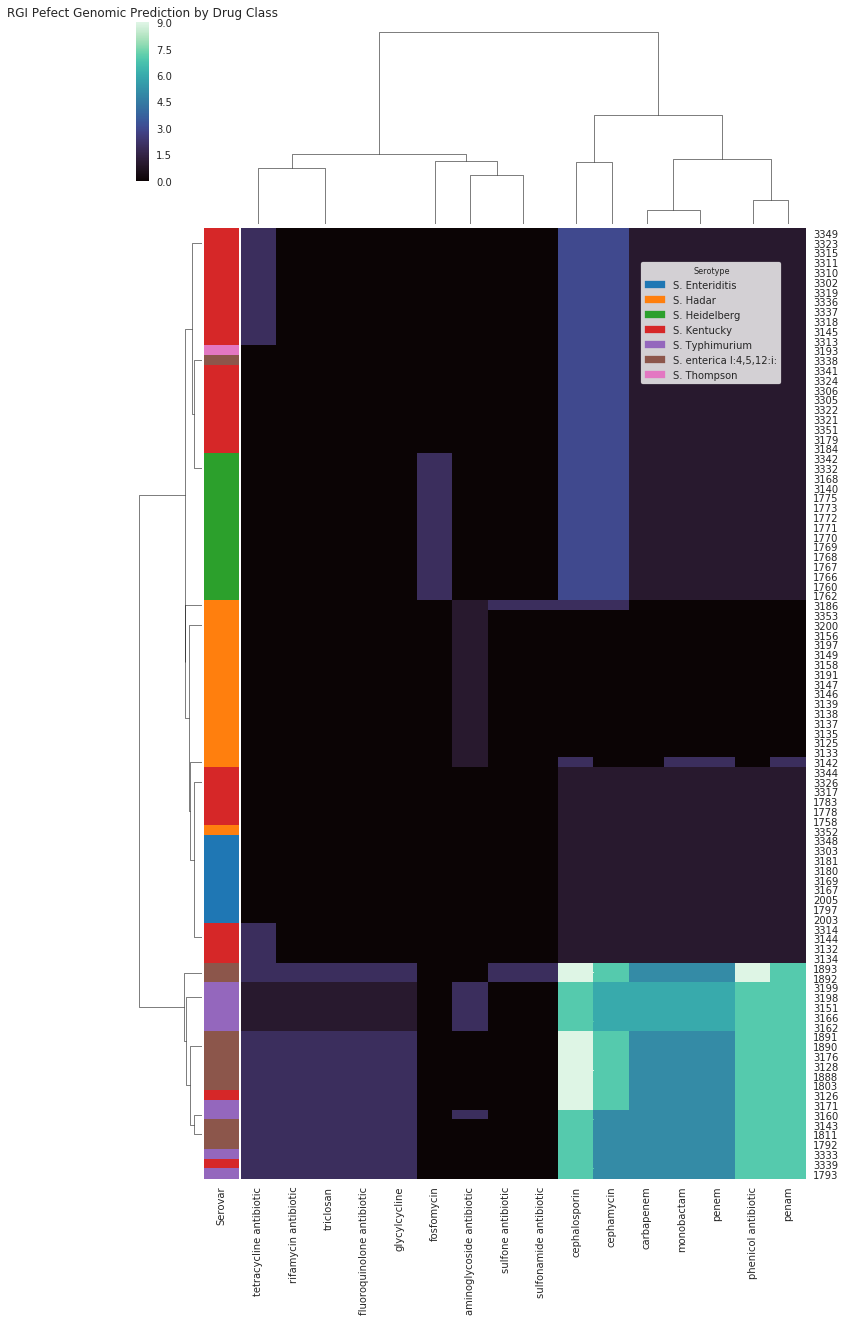

In [44]:
def get_drug_class_df(drug_class_dict):
    all_drug_classes = set()
    for drug_set in list(drug_class_dict.values()):
        all_drug_classes = all_drug_classes.union(drug_set)

    df = pd.DataFrame(index=drug_class_dict.keys(), columns=all_drug_classes)
    df = df.fillna(0)
    for genome_id, drug_resistances in drug_class_dict.items():
        for drug in drug_resistances:
            df.loc[genome_id, drug] += 1
    
    return df

df = get_drug_class_df(perfect_drug_class)
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')
#_ = plt.ylabel('S                      I                    R')
plt.title("RGI Pefect Genomic Prediction by Drug Class")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.7,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

save_figure('amr/rgi_perfect_drug_class')

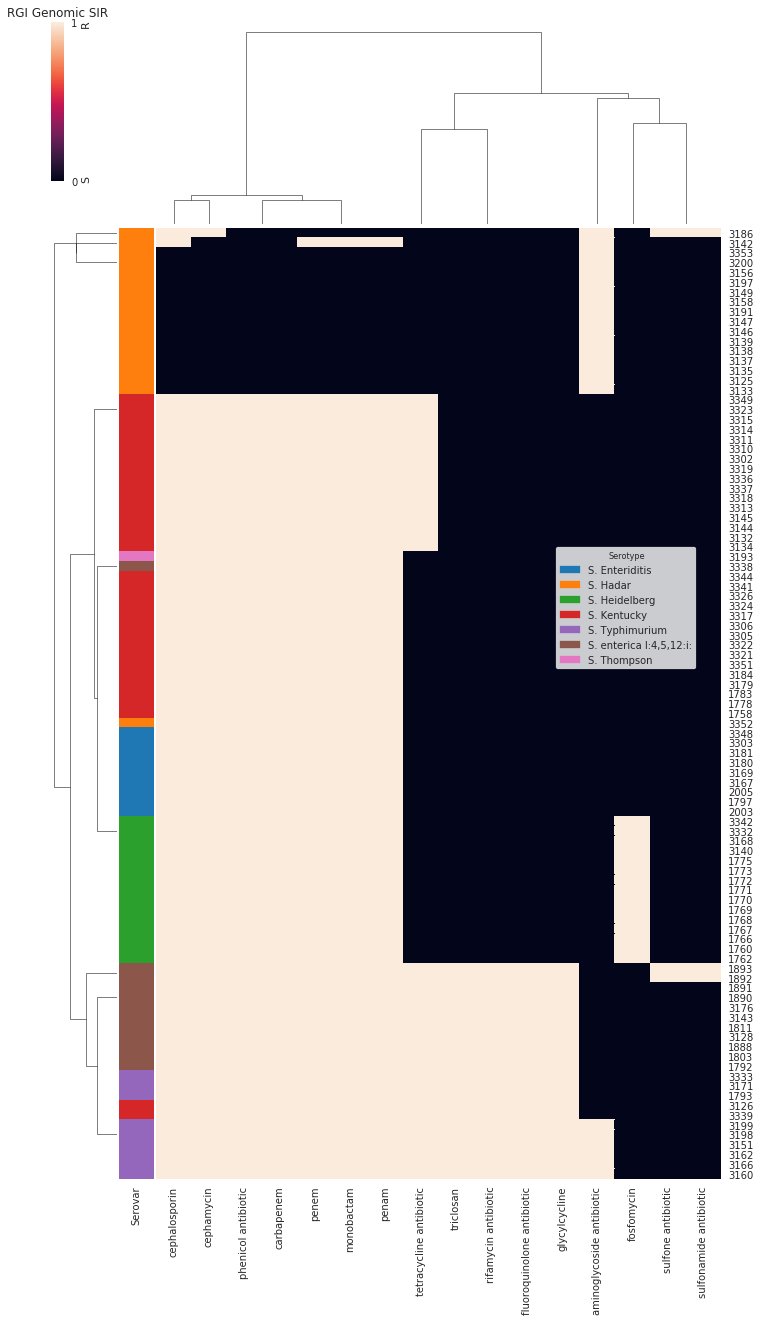

In [45]:
# let's get a binary plot
df = get_drug_class_df({k: set(v) for k,v in perfect_drug_class.items()})
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cbar_kws={'ticks': [0,1,2]})

_ = plt.ylabel('S                                          R')
plt.title("RGI Genomic SIR")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.7,0.6),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

save_figure('amr/rgi_perfect_drug_class_binary')

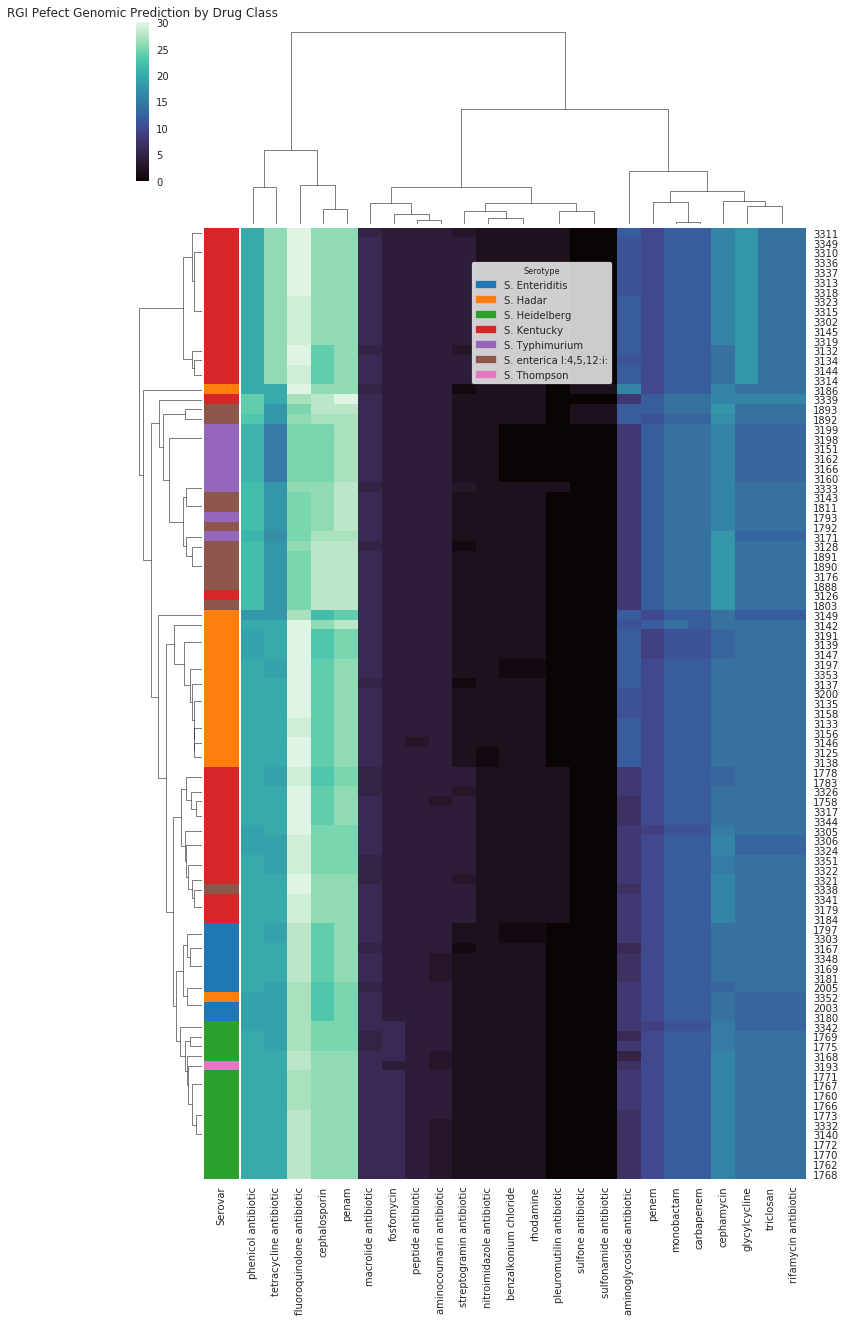

In [46]:
df = get_drug_class_df(drug_class)
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("RGI Pefect Genomic Prediction by Drug Class")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.4,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
save_figure('amr/rgi_drug_class.pdf')

In [47]:
rgi_encoded = pd.DataFrame(index=ast_df.index, columns=set(rgi_results['Best_Hit_ARO'].values)).fillna(0)
rgi_encoded_perfect = pd.DataFrame(index=ast_df.index, columns=set(rgi_results[rgi_results['Cut_Off']=='Perfect']['Best_Hit_ARO'].values)).fillna(0) 

for genome_id, rgi_data in rgi_results.iterrows():
    if rgi_data['Cut_Off'] == 'Perfect':
        rgi_encoded_perfect.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1
        rgi_encoded.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1
    else:
        rgi_encoded.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1

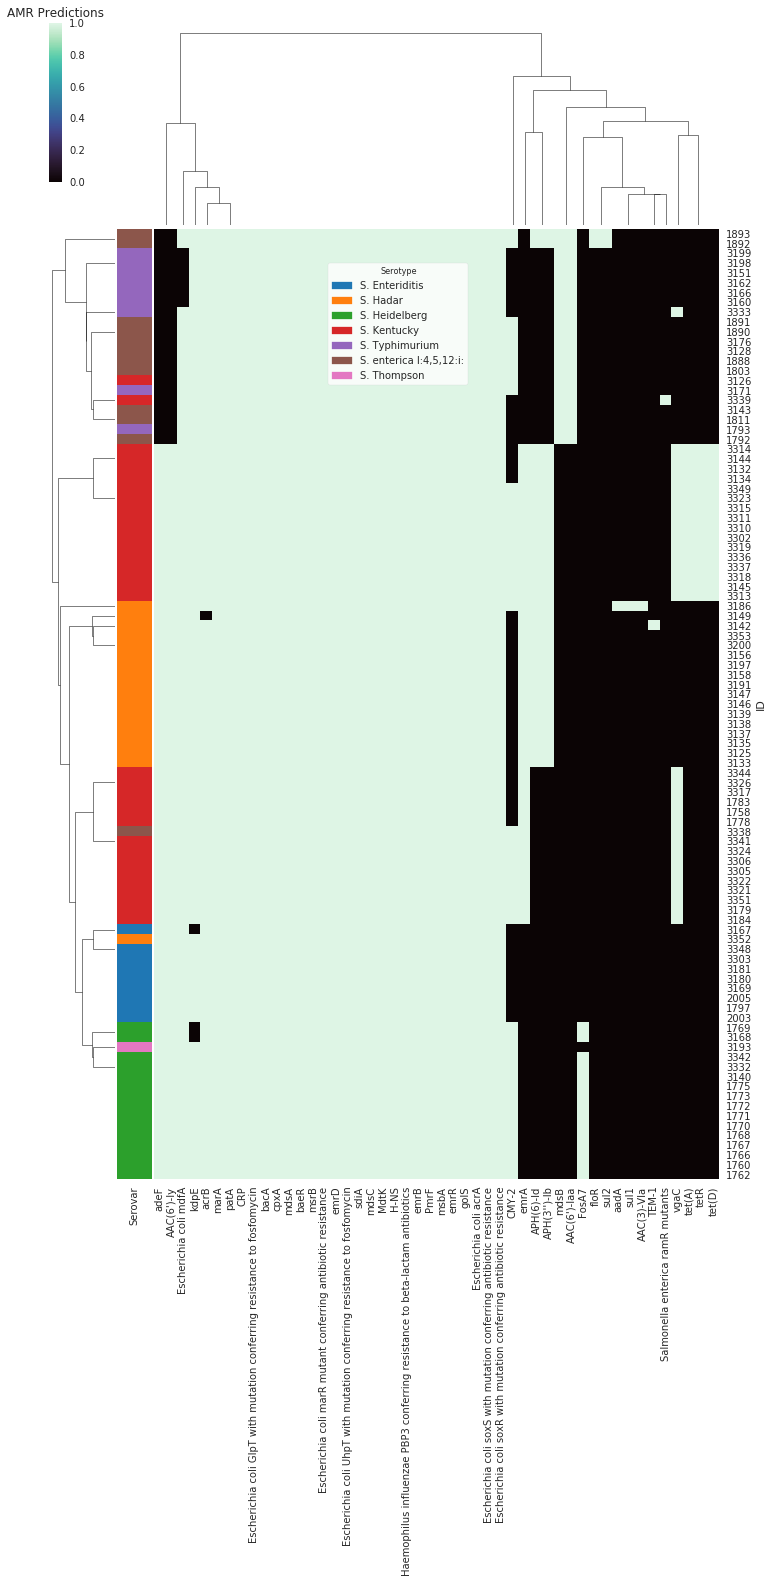

In [48]:
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]

g = sns.clustermap(rgi_encoded, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("AMR Predictions")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.3,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
save_figure('amr/aro_clustermap')

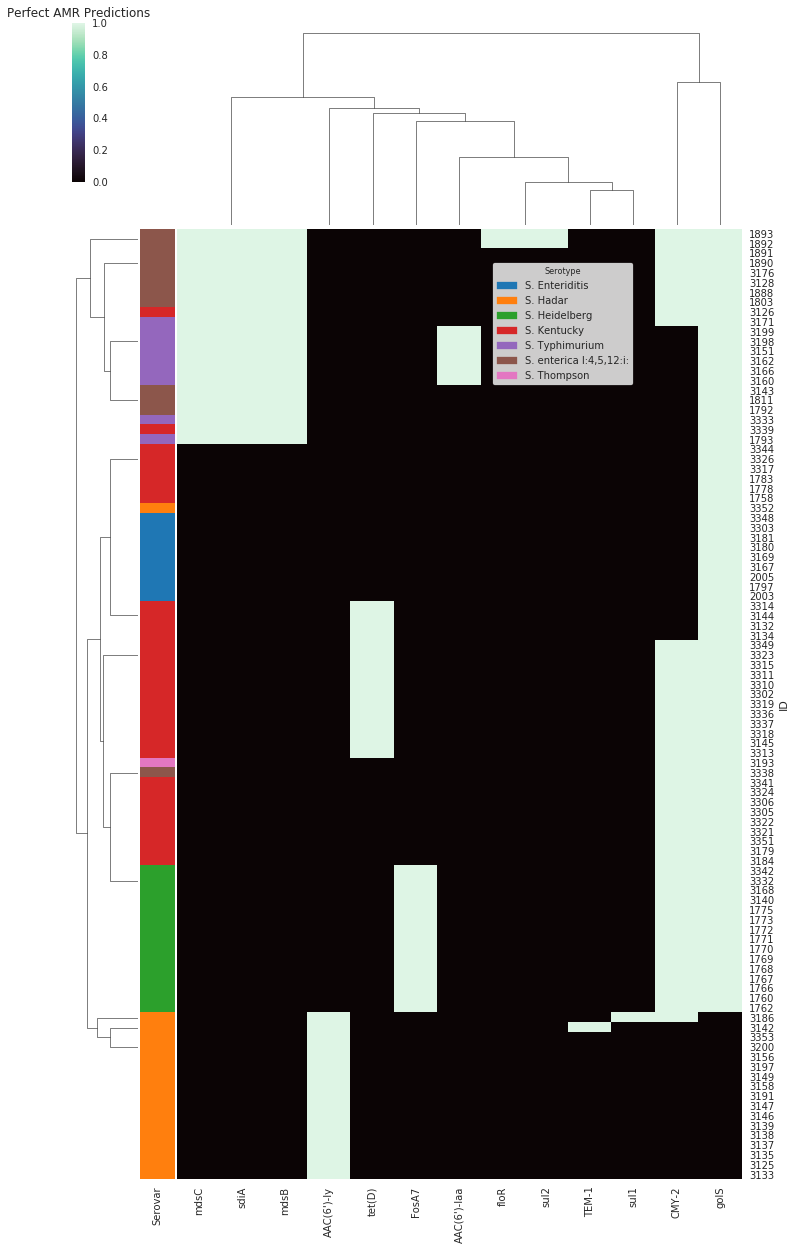

In [49]:
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]

g = sns.clustermap(rgi_encoded_perfect, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("Perfect AMR Predictions")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.55,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
save_figure('amr/perfect_aro_clustermap')

In [50]:
drug_class_translation = {'AMOCA':  ['penam'],
                          'AMPICI': ['penam'],
                          'AZITHR': ['macrolide antibiotic'],
                          'CEFOXI': ['cephamycin'],
                          'CEFTIF': ['cephalosporin'],
                          'CEFTRI': ['cephalosporin'],
                          'CHLORA': ['phenicol antibiotic'],
                          'CIPROF': ['fluoroquinolone antibiotic'],
                          'GENTAM': ['aminoglycoside antibiotic'],
                          'NALAC':  ['fluoroquinolone antibiotic'],
                          'STREPT': ['aminoglycoside antibiotic'],
                          'SULFIZ': ['sulfonamide antibiotic'],
                          'TETRA':  ['tetracycline antibiotic'],
                          'TRISUL': ['sulfonamide antibiotic', 'diaminopyrimidine antibiotic']}

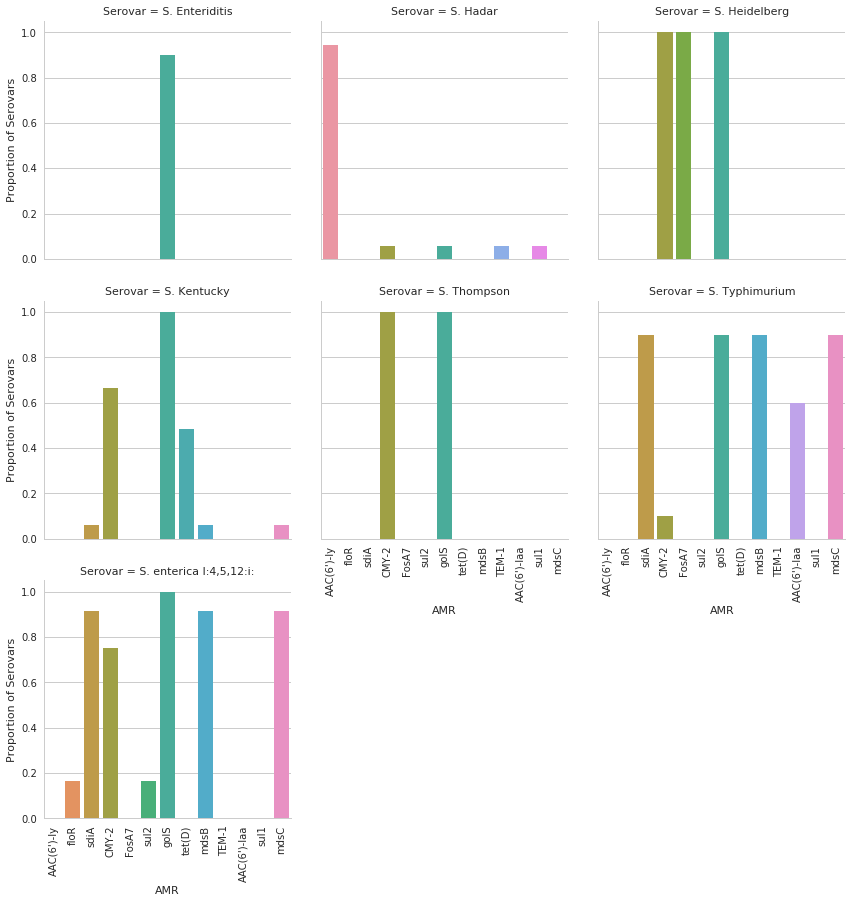

In [51]:
# normalise
rgi_encoded_perfect['Serovar'] = ast_df['Serovar']
df = rgi_encoded_perfect.groupby("Serovar").sum()
df = df.transpose().div(total_serovars_in_dataset, axis=1).transpose()
df = pd.melt(df.reset_index(), id_vars = 'index')
df = df.rename(columns={'index': 'Serovar', 'variable': 'AMR', 'value': 'Proportion of Serovars'})

g = sns.factorplot(data = df, x='AMR', col='Serovar', col_wrap=3, y="Proportion of Serovars", kind='bar')
g.set_xticklabels(rotation=90)
save_figure('amr/perfect_rgi_by_serovar')

### Comparing Genotyping to AST

#### Assessing Genotype to Phenotype by FDA standards

Essential Agreement (EA): Agreement within plus or minus one two-fold dilution of reference MIC;

Category Agreement (CA): Agreement of interpretive results (Susceptible (S), Intermediate (I), or Resistant (R));

major discrepancy (maj): The reference category result is S and the new method result is R; and very major discrepancy; 
and (vmj): The reference category result is R and the new method result is S.

In [52]:
# from the card database assuming nalac is nalidixic acid
drug_class_translation = {'AMOCLA':  ['penam'],
                          'AMPICI': ['penam'],
                          'AZITHR': ['macrolide antibiotic'],
                          'CEFOXI': ['cephamycin'],
                          'CEFTIF': ['cephalosporin'],
                          'CEFTRI': ['cephalosporin'],
                          'CHLORA': ['phenicol antibiotic'],
                          'CIPROF': ['fluoroquinolone antibiotic'],
                          'GENTAM': ['aminoglycoside antibiotic'],
                          'NALAC':  ['fluoroquinolone antibiotic'],
                          'STREPT': ['aminoglycoside antibiotic'],
                          'SULFIZ': ['sulfonamide antibiotic'],
                          'TETRA':  ['tetracycline antibiotic'],
                          'TRISUL': ['sulfonamide antibiotic', 'diaminopyrimidine antibiotic']}

# get reverse lookup
drug_class_translation_rev = {}
for key, value in drug_class_translation.items():
    for rgi_drug in value:
        if rgi_drug not in drug_class_translation_rev:
            drug_class_translation_rev.update({rgi_drug : [key]})
        else:
            drug_class_translation_rev[rgi_drug].append(key)


In [53]:
rgi_sir = pd.DataFrame(index=ast_df.index, columns=ast_df.columns)
rgi_sir = rgi_sir.drop('Date Read', axis=1)
rgi_sir['Serovar'] = ast_df['Serovar']


df = rgi_results
for row in df.iterrows():
    ix = row[0]
    data = row[1]
    if type(data['Drug Class']) == float:
        print(data['Best_Hit_ARO'], ' missing drug class information')
        data['Drug Class'] = ''
    drug_classes = [x.strip() for x in data['Drug Class'].split(';')]
    for drug in drug_classes:
        if drug in drug_class_translation_rev:
            for ast_class in drug_class_translation_rev[drug]:
                rgi_sir.loc[ix,ast_class] = 'R'
        # add drug classes not in the ast 
        else:
            if drug not in rgi_sir.columns:
                rgi_sir[drug] = np.nan
                rgi_sir.loc[ix, drug] = 'R'
            else:
                rgi_sir.loc[ix, drug] = 'R'
                
# genotypically all the missing are 'S'
rgi_sir = rgi_sir.fillna('S')

emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
e

In [54]:
rgi_sir_perfect = pd.DataFrame(index=ast_df.index, columns=ast_df.columns)
rgi_sir_perfect = rgi_sir_perfect.drop('Date Read', axis=1)
rgi_sir_perfect['Serovar'] = ast_df['Serovar']


df = rgi_results[rgi_results['Cut_Off'] == 'Perfect']
for row in df.iterrows():
    ix = row[0]
    data = row[1]
    
    drug_classes = [x.strip() for x in data['Drug Class'].split(';')]
    for drug in drug_classes:
        if drug in drug_class_translation_rev:
            for ast_class in drug_class_translation_rev[drug]:
                rgi_sir_perfect.loc[ix,ast_class] = 'R'
        # add drug classes not in the ast 
        else:
            if drug not in rgi_sir_perfect.columns:
                rgi_sir_perfect[drug] = np.nan
                rgi_sir_perfect.loc[ix, drug] = 'R'
            else:
                rgi_sir_perfect.loc[ix, drug] = 'R'
                
# genotypically all the missing are 'S'
rgi_sir_perfect = rgi_sir_perfect.fillna('S')

In [55]:
def tally_FDA(rgi_df, ast_df):
    drugs = ['AMOCLA', 'AMPICI', 'AZITHR', 'CEFOXI',
       'CEFTIF', 'CEFTRI', 'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'STREPT',
       'SULFIZ', 'TETRA', 'TRISUL']
    fda_perf = pd.DataFrame(index=ast_df.index, columns = ['Categorical Agreement',
                                                           'Major Disagreement',
                                                           'Very Major Disagreement'])
    fda_perf = fda_perf.fillna(0)
    fda_perf['Serovar'] = ast_df['Serovar']
    
    rgi_df = rgi_df.loc[:, drugs]
    ast_df = ast_df.drop('Date Read', axis=1).loc[:, drugs]
    
    # as we aren't predicting 'I'
    ast_df = ast_df.replace('I', 'R')
    
    # to just go over the cols with ast results
    for ix, ast in ast_df.loc[:, drugs].iterrows():
        for drug, sir in ast.iteritems():
            if sir == rgi_df.loc[ix, drug]:
                fda_perf.loc[ix, 'Categorical Agreement'] += 1 
            elif sir == 'S' and rgi_df.loc[ix, drug] == 'R':
                fda_perf.loc[ix, 'Major Disagreement'] += 1
            elif sir == 'R' and rgi_df.loc[ix, drug] == 'S':
                fda_perf.loc[ix, 'Very Major Disagreement'] += 1
            else:
                assert False
    return fda_perf

fda_perf = tally_FDA(rgi_sir, ast_df) 
fda_perf_perfect = tally_FDA(rgi_sir_perfect, ast_df)

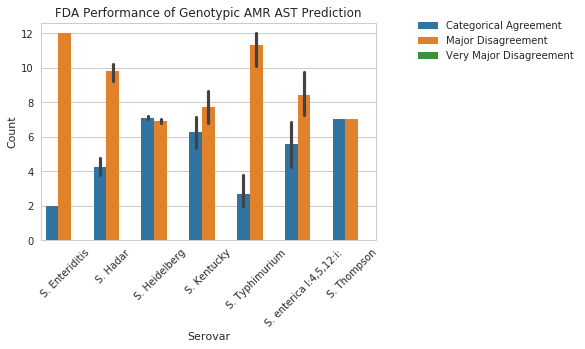

In [56]:
df = pd.melt(fda_perf, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('FDA Performance of Genotypic AMR AST Prediction')
save_figure('amr/fda_rgi_amr')

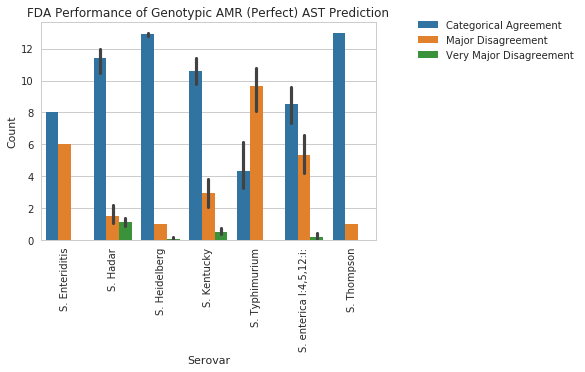

In [57]:
df = pd.melt(fda_perf_perfect, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('FDA Performance of Genotypic AMR (Perfect) AST Prediction')
save_figure('amr/fda_rgi_amr_perfect')

So relatively good but with 'strict' its basically resistant to everything therefore the no vmaj. Perfect seems to be more reasonable.  Interesting that Typhmimurium and Enteriditis are so bad even with perfect cut_off.

In [58]:
print(rgi_sir_perfect.columns)
print(rgi_sir.columns)

Index(['Serovar', 'AMOCLA', 'AMPICI', 'AZITHR', 'CEFOXI', 'CEFTIF', 'CEFTRI',
       'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'STREPT', 'SULFIZ', 'TETRA',
       'TRISUL', 'monobactam', 'carbapenem', 'penem', 'sulfone antibiotic',
       'fosfomycin', 'glycylcycline', 'rifamycin antibiotic', 'triclosan'],
      dtype='object')
Index(['Serovar', 'AMOCLA', 'AMPICI', 'AZITHR', 'CEFOXI', 'CEFTIF', 'CEFTRI',
       'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'STREPT', 'SULFIZ', 'TETRA',
       'TRISUL', 'benzalkonium chloride', 'rhodamine',
       'nitroimidazole antibiotic', 'glycylcycline', 'rifamycin antibiotic',
       'triclosan', 'monobactam', 'carbapenem', 'penem',
       'streptogramin antibiotic', 'aminocoumarin antibiotic',
       'peptide antibiotic', '', 'fosfomycin', 'sulfone antibiotic',
       'pleuromutilin antibiotic'],
      dtype='object')


Might also be worth testing drugs from 'monobactam', 'carbapenem', 'penem', 'sulfone antibiotic',
       'fosfomycin', 'glycylcycline', 'rifamycin antibiotic', 'triclosan' as these had perfect hits but no AST data
       
emrD is also an unknown factor

#### Machine Learning 

AKA can this be improved by not using the RGI drug classes directly but by training a classifier.

In [59]:
from sklearn.model_selection import train_test_split

# to make it useable and encode it
sr_ast = ast_df.drop(['Serovar', 'Date Read'], axis=1)
sr_ast = sr_ast.replace('S', 0)
sr_ast = sr_ast.replace('I', 1)
sr_ast = sr_ast.replace('R', 1)

rgi_train, rgi_test, sr_train, sr_test = train_test_split(rgi_encoded.as_matrix(), 
                                                             sr_ast.as_matrix(), 
                                                             test_size=0.25, 
                                                             random_state=42)

rgi_perfect_train, rgi_perfect_test, sr_train, sr_test = train_test_split(rgi_encoded_perfect.drop('Serovar', axis=1).as_matrix(), 
                                                                          sr_ast.as_matrix(), 
                                                                          test_size=0.25, 
                                                                          random_state=42)

In [61]:
# to use for scoary analysis
sr_ast.to_csv('amr/scoary/ast_df.csv')

In [60]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV


def compare_clf(X_train, X_test, y_train, y_test):

    names = ["DT", "ET", "ETs", "RF",
             "KN", "RN", "MLP", "RC"]

    classifiers = [
        DecisionTreeClassifier(),
        ExtraTreeClassifier(),
        ExtraTreesClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(), 
        MLPClassifier()]
        # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        print(name, clf.score(X_test, y_test))
     
        

In [61]:
compare_clf(rgi_train, rgi_test, sr_train, sr_test)

DT 0.76
ET 0.76
ETs 0.76
RF 0.76
KN 0.64
RN 0.8


/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [62]:
compare_clf(rgi_perfect_train, rgi_perfect_test, sr_train, sr_test)

DT 0.8
ET 0.8
ETs 0.8
RF 0.8
KN 0.8
RN 0.8


/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [63]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, jaccard_similarity_score, hamming_loss, log_loss, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

hyperparam_grid = {'n_estimators': range(10,100,10), 'criterion':['gini', 'entropy'], 'class_weight': ['balanced', None], "bootstrap": [True, False]}
                   #'max_depth': [None] + list(range(5,100,10)), 'min_samples_split' : range(2,10),
                   #'min_samples_leaf' : range(1,10), 

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

rf_r_cv = RandomizedSearchCV(RandomForestClassifier(), hyperparam_grid, n_iter=25) #scoring=scoring, refit=False)
rf_r_cv.fit(rgi_train, sr_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [64]:
report(rf_r_cv.cv_results_)

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 40, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 50, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 30, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 30, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 30, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 70, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, jaccard_similarity_score, hamming_loss, log_loss, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

hyperparam_grid = {'n_estimators': range(10,100,10), 'criterion':['gini', 'entropy'], 'class_weight': ['balanced', None], "bootstrap": [True, False]}
                   #'max_depth': [None] + list(range(5,100,10)), 'min_samples_split' : range(2,10),
                   #'min_samples_leaf' : range(1,10), 

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

perf_rf_r_cv = RandomizedSearchCV(RandomForestClassifier(), hyperparam_grid, n_iter=25) #scoring=scoring, refit=False)
perf_rf_r_cv.fit(rgi_perfect_train, sr_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [66]:
report(perf_rf_r_cv.cv_results_)

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 60, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 90, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 10, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 40, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 20, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 30, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 

So best performing RF is: n_estimators': 70, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False

In [86]:
clf = RandomForestClassifier(n_estimators=70, criterion='entropy', class_weight=None, bootstrap=False)
perf_clf = RandomForestClassifier(n_estimators=70, criterion='entropy', class_weight=None, bootstrap=False)

clf.fit(rgi_train, sr_train)
perf_clf.fit(rgi_perfect_train, sr_train)

print('ALL RGI')
print(metrics.classification_report(clf.predict(rgi_test), sr_test, target_names=sr_ast.columns))

print('Perfect RGI')
print(metrics.classification_report(perf_clf.predict(rgi_perfect_test), sr_test, target_names=sr_ast.columns))

ALL RGI
             precision    recall  f1-score   support

     AMOCLA       1.00      1.00      1.00         9
     AMPICI       1.00      1.00      1.00         9
     AZITHR       0.00      0.00      0.00         0
     CEFOXI       1.00      1.00      1.00         9
     CEFTIF       1.00      1.00      1.00         9
     CEFTRI       0.89      1.00      0.94         8
     CHLORA       0.00      0.00      0.00         0
     CIPROF       0.00      0.00      0.00         0
     GENTAM       0.00      0.00      0.00         0
      NALAC       0.00      0.00      0.00         0
     STREPT       0.88      0.70      0.78        10
     SULFIZ       0.00      0.00      0.00         0
      TETRA       0.78      0.78      0.78         9
     TRISUL       0.00      0.00      0.00         0

avg / total       0.93      0.92      0.93        63

Perfect RGI
             precision    recall  f1-score   support

     AMOCLA       0.89      1.00      0.94         8
     AMPICI       0.89

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [87]:
ml_prediction = clf.predict(rgi_encoded)
ml_prediction = pd.DataFrame(ml_prediction, index=rgi_encoded.index, 
                             columns=ast_df.drop(['Serovar', 'Date Read'], axis=1).columns).replace(0, 'S').replace(1, 'R')

perf_ml_prediction = perf_clf.predict(rgi_encoded_perfect.drop('Serovar', axis=1))
perf_ml_prediction = pd.DataFrame(perf_ml_prediction, index=rgi_encoded.index, 
                             columns=ast_df.drop(['Serovar', 'Date Read'], axis=1).columns).replace(0, 'S').replace(1, 'R')


In [88]:
ml_fda = tally_FDA(ml_prediction, ast_df)
perf_ml_fda = tally_FDA(perf_ml_prediction, ast_df)

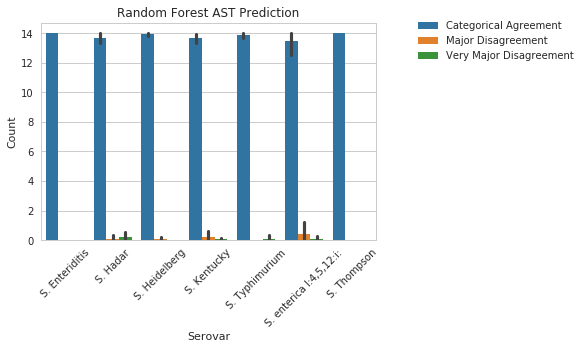

In [89]:
df = pd.melt(ml_fda, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Random Forest AST Prediction')
save_figure('amr/rf_ast_prediction_fda')

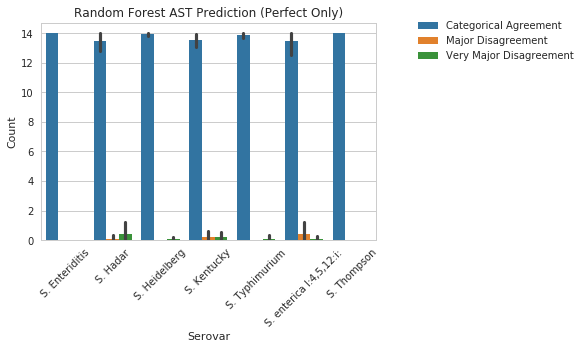

In [102]:
df = pd.melt(perf_ml_fda, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Random Forest AST Prediction (Perfect Only)')
_ = plt.xticks(rotation=45)
save_figure('amr/rf_ast_prediction_perfect_fda')

In [93]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
X=rgi_encoded
for f in range(X.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_encoded.columns[f], importances[indices[f]]))

# broken ccurrently to fix
# Plot the feature importances of the forest
#plt.figure(figsize=(10,5))
#plt.title("RandomForest AST Prediction Feature Importances")
##plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.ylabel('Mean Feature Importance')
#plt.xlabel('AMR Determinants')
#plt.xticks(range(X.shape[1]), rgi_encoded.columns[indices], rotation=90)
#plt.xlim([-1, X.shape[1]])
#plt.show()
#save_figure('amr/rf_feature_importances')

Feature ranking:
1. feature: msrB (0.4427317315796037)
2. feature: marA (0.10603389541131297)
3. feature: CMY-2 (0.08302011574334817)
4. feature: FosA7 (0.06297537771800127)
5. feature: patA (0.03740405363318742)
6. feature: Salmonella enterica ramR mutants (0.031857591619002625)
7. feature: MdtK (0.02965701367063607)
8. feature: baeR (0.0285086149945608)
9. feature: golS (0.02828108003771775)
10. feature: sdiA (0.022765581316576963)
11. feature: Escherichia coli mdfA (0.02130554020222472)
12. feature: CRP (0.020974872424250533)
13. feature: emrB (0.01848107745815424)
14. feature: Escherichia coli GlpT with mutation conferring resistance to fosfomycin (0.015219651989113094)
15. feature: mdsB (0.011711784959312107)
16. feature: adeF (0.010200534750402643)
17. feature: Escherichia coli marR mutant conferring antibiotic resistance (0.01008942103879622)
18. feature: msbA (0.009396713214728913)
19. feature: PmrF (0.008302068228229828)
20. feature: emrD (0.001083280010839786)
21. feature: Es

Worrying that emrD is so important despite not being associated with a drug class in CARD

In [94]:
importances = perf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
X=rgi_encoded_perfect.drop('Serovar', axis=1)
for f in range(X.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_encoded_perfect.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("RandomForest AST Prediction Feature Importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

#plt.xticks(range(X.shape[1]), rgi_encoded_perfect.columns[indices], rotation=90)
#plt.xlim([-1, X.shape[1]])
#plt.ylabel('Mean Feature Importance')
#plt.xlabel('AMR Determinants')
#plt.show()
#save_figure('amr/rf_perfect_feature_importances')

Feature ranking:
1. feature: TEM-1 (0.4292296180649502)
2. feature: mdsB (0.1340809852751614)
3. feature: sul2 (0.11099453744496704)
4. feature: CMY-2 (0.08992778810736618)
5. feature: FosA7 (0.06746262227604395)
6. feature: AAC(6')-Iy (0.05112990719100172)
7. feature: golS (0.03313276489056234)
8. feature: sul1 (0.023036191679681777)
9. feature: floR (0.022457461789553313)
10. feature: tet(D) (0.014084924336603891)
11. feature: sdiA (0.012514056483209345)
12. feature: AAC(6')-Iaa (0.011949142460898924)
13. feature: mdsC (0.0)


Suspect this is probably overfitted to all hell.

#### Kovar 

Let's see how well we can perform without RGI labelling by just directly applying Kover/set covering machine approach to the contigs.

Might be interesting/redundant to use the methods used in https://www.biorxiv.org/content/biorxiv/early/2018/06/04/338194.full.pdf

Kover requires TSVs of the genomes `Genome_ID\tFasta_Path` and the metadata: separate files for each antibiotic `Genome_ID\t[1,0]` depending on resistance status

In [124]:
# create the resistance metadata files
for col in sr_ast:
    with open('amr/kover/metadata/{}_metadata.tsv'.format(col), 'w') as fh:
        for ix, line in zip(sr_ast[col].index, sr_ast[col].values):
            fh.write("{}\t{}\n".format(ix.strip(), int(line)))

In [127]:
sr_ast['CEFOXI'].value_counts()

0    49
1    48
Name: CEFOXI, dtype: int64

In [122]:
# create the genome metadata files
genome_metadata = []
for assembly_id in ast_df.index:
    genome_path = glob('genomes/{}_irida-submission-*.fasta'.format(assembly_id))
    if len(genome_path) == 1:
        genome_metadata.append((assembly_id, os.path.abspath(genome_path[0])))
    elif len(genome_path) > 1:
        print("Multiple hits")
    else:
        print("Assembly missing")

with open('amr/kover/metadata/genome_metadata.tsv', 'w') as fh:
    for ix, line in genome_metadata:
        fh.write('{}\t{}\n'.format(ix, line))

Let's try just cefotaxin first as its a the human alternative antibiotic of choice for Salmonella that we have in our dataset and has resistance (Ciprofloxacin is first choice but no resistance in our taxa)
`./kover/bin/kover dataset create from-contigs --genomic-data metadata/genome_metadata.tsv --phenotype-name cefotaxin --phenotype-metadata metadata/CEFOXI_metadata.tsv --output cefotaxin_dataset -x --n-cpu 1`

## CMY-2 Analysis

AAFC is really interested in CMY-2 so I grabbed all the fragments containing CMY-2 data. This does appear the most important determinant of the observed AST.

Basically, used cardprev and card canonical CMY-2 sequences to build nucleotide MSA.

Trained HMMer on that and searched the genomes using that via `search_for_cmy2.sh` script.

Then `get_cmy2_locus.py` was used to grab all CMY-2 loci within 5kbp of the cmy2 seq into `cmy2_loci.fasta` and the whole contigs  `cmy2_contig.fasta`.


Contigs were annotated using prokka:
`prokka --genus Salmonella --species enterica -gram neg --cpus=1 --evalue 1e-05 cmy2_contig.fasta --outdir cmy2_contig_annotation` and output to `CMY2_analysis/cmy2_contig_annotation`

In [70]:
headers = 'seqname source feature start end score strand frame attribute'.split()

with open('CMY2_analysis/cmy2_contig_annotation/PROKKA_06122018.gff') as fh:
    with open('CMY2_analysis/cmy2_contig_annotation/prokka_gff_to_tsv', 'w') as out_fh:
        for line in fh:
            if not line.startswith('##'):
                out_fh.write(line)
            if line.startswith('>'):
                break

cmy2_df = pd.read_csv('CMY2_analysis/cmy2_contig_annotation/prokka_gff_to_tsv', sep='\t', names = headers)
cmy2_df['gene'] = cmy2_df['attribute'].str.split('product=').str.get(-1)

cmy2_df = cmy2_df[cmy2_df['gene'] != 'Beta-lactamase']

In [72]:
cmy2_df = cmy2_df[['seqname', 'gene']]

co_occurence = {}
for ix, row in cmy2_df.iterrows():
    if row['gene'] not in co_occurence:
        co_occurence.update({row['gene']: [row['seqname']]})
    else:
        co_occurence[row['gene']].append(row['seqname'])

co_occurence_count = []
for gene_name, contig_set in co_occurence.items():
    co_occurence_count.append([gene_name, len(set(contig_set))])


([], <a list of 0 Text xticklabel objects>)

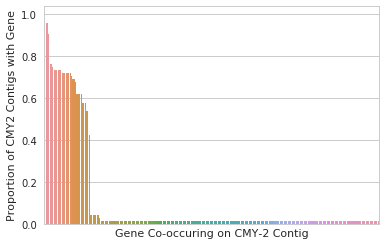

In [73]:
df = pd.DataFrame(co_occurence_count, columns=['Gene Co-occuring on CMY-2 Contig', 'Number of Co-occurences'])
df['Proportion of CMY2 Contigs with Gene'] = df['Number of Co-occurences'] / 71
df = df.sort_values('Proportion of CMY2 Contigs with Gene', ascending=False)

sns.barplot(x='Gene Co-occuring on CMY-2 Contig', y="Proportion of CMY2 Contigs with Gene", data=df)
plt.xticks([])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

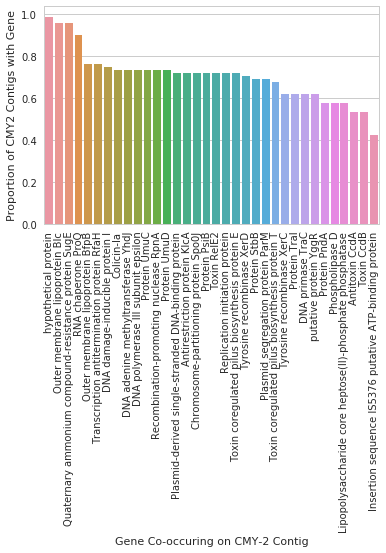

In [74]:
df = df[df['Proportion of CMY2 Contigs with Gene'] > 0.25]
sns.barplot(x='Gene Co-occuring on CMY-2 Contig', y="Proportion of CMY2 Contigs with Gene", data=df)
plt.xticks(rotation=90)

## Virulence Factor Analysis